In [1]:
from model_synthdata_inversion import (density_atm, density_fume, 
                                       temperature_fume, heat_capacity, 
                                       produce_Gm, objective_fn, derivs)
from itertools import product
from myiapws import iapws1992, iapws1995
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

cm = 1 / 2.54

## True conditions

/home/david/Modelling/fumarolePlumeModel/model_synthdata_inversion.py:40: RuntimeWarning: invalid value encountered in sqrt
  dQ  = 2 * rhoa * Ue * Q / (np.sqrt(rho * M))
/home/david/Modelling/fumarolePlumeModel/model_synthdata_inversion.py:43: RuntimeWarning: invalid value encountered in sqrt
  + 2 * rhoa * Q / (np.sqrt(rho * M)) * Ue * W * np.cos(th)
/home/david/Modelling/fumarolePlumeModel/model_synthdata_inversion.py:47: RuntimeWarning: invalid value encountered in sqrt
  - 2 * rhoa * np.sqrt(M / rho) * Ue * W * np.cos(th)
/home/david/Modelling/fumarolePlumeModel/model_synthdata_inversion.py:50: RuntimeWarning: invalid value encountered in sqrt
  - 2 * rhoa * Q / (M * np.sqrt(rho * M)) * Ue * W * np.sin(Q)


1.0


ValueError: operands could not be broadcast together with shapes (6,) (1467,) 

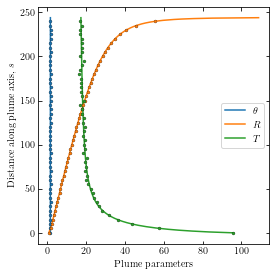

In [2]:
rho0 = 0.5   # careful, density will vary with temperature!
Cp0  = 1885  # careful, Cp0 will vary with temperatur!e
Rp0  = 462   # careful, Rp0 will vary with temperatur!e
Pa0  = 86000 # Atmospheric pressure at altitude of la Soufrière
theta0 = np.pi/2
n0   = 0.05  # Fumarole plumes are always 95% vapour?
Ta0  = 291   # Tair 2-year average at Sanner
npts = 501
s    = np.linspace(0, 250, npts)
Tt   = iapws1995.Tt

# variables
N  = 21
R0 = np.linspace(0.1, 1, N)  
T0 = np.linspace(80 + Tt, 160 + Tt, N)
u0 = np.linspace(0.1, 100, N)

rho0true = .5
R0true = .5
T0true = Tt + 96
u0true = 10
Q0true = rho0true * u0true * R0true**2 * np.pi
M0true = Q0true * u0true
E0true = Q0true * Cp0 * T0true
V0true = [Q0true, M0true, E0true, theta0, Pa0, n0]

sol_true = solve_ivp(derivs, [s[0], s[-1]], V0true, t_eval=s)

# Produce "true" data values
sol  = sol_true
rho  = density_fume(sol.t, sol.y)
T    = temperature_fume(sol.t, sol.y) - Tt
Cp   = heat_capacity(sol.t, sol.y)
b    = sol.y[0] / np.sqrt(rho * sol.y[1])
u    = sol.y[1] / sol.y[0]
theta = sol.y[3]

cutoff = b.argmax()
s = s[:cutoff]
b = b[:cutoff]
u = u[:cutoff]
T = T[:cutoff]
theta = theta[:cutoff]

sigtheta, sigb, sigT = np.pi / 20, .1, .5  # rad, m and K
Cd_inv = np.diag(np.array([1 / sigtheta**2 * np.ones_like(theta),
                           1 / sigb**2 * np.ones_like(b),
                           1 / sigT**2 * np.ones_like(T)]).ravel())

solp = np.array([theta, b, T])
noise = np.random.randn(*solp.shape)  # Gaussian noise, _N_(0,1)
sol_noise = (solp.T + noise.T * (sigtheta, sigb, sigT)).T
d    = sol_noise.flatten()  # array of data
Gm   = produce_Gm(sol, cutoff)
Gm_d = Gm - d

fig0, ax0 = plt.subplots(figsize=(10*cm, 10*cm))
ax0.plot(solp.T, s, '-')
ax0.set_xlabel('Plume parameters')
ax0.set_ylabel(r'Distance along plume axis, $s$')
ax0.legend((r'$\theta$', r'$R$', r'$T$'))

plt.gca().set_prop_cycle(None)  # reset colour cycle
# ax0.plot(sol_noise.T, s, '.')

fig0.tight_layout()
fig0.savefig('./images/synthetic_model_data.pdf', dpi=300)

skip = 10
ax0.plot(sol_noise.T[::skip], s[::skip], '.')
fig0.savefig('./images/synthetic_model_data_noise.pdf', dpi=300)

E = objective_fn(Gm, d, np.diag(Cd_inv), mode='abs')
print(E)

opt_V0 = minimize(objective_fn, x0=V0true, method='Nelder-Mead', args=(d, np.diag(Cd_inv), 'abs'), )

In [ ]:
print(d.reshape((3, -1)).shape)

print(sol)

In [5]:
def parallel_job(u0, R0, T0):
    warnings.filterwarnings('ignore')
    V0   = [1, 1, Cp0 * T0, 1, 1, .05]  # required for routines
    rho0 = density_fume(0, V0)
    Q0   = rho0 * np.pi * R0**2 * u0
    M0   = Q0 * u0
    E0   = Q0 * Cp0 * T0
    V0   = [Q0, M0, E0, np.pi/2, Pa0, .05]

    sol  = solve_ivp(derivs, [s[0], s[-1]], V0, t_eval=s)
    
    Gm   = produce_Gm(sol, cutoff)

    return objective_fn(Gm, d, Cd_inv, mode='lstsq'), V0

In [6]:
njobs = 16
ngrid = 21
u0 = u0true  # np.linspace(.1, 100, ngrid)
R0 = np.linspace(.1, 10,  ngrid)
T0 = np.linspace(60, 150, ngrid) + Tt

sequence = [u0, R0, T0]

t = time.time()
sequence = [R0, T0]
objFn, initialConds = [], []

results = Parallel(n_jobs=njobs)(delayed(parallel_job)(u0, R0_, T0_) 
                                 for (R0_, T0_) in list(product(*sequence)))
# for (u0_, R0_, T0_) in list(product(*sequence)):
#     print(u0_, R0_, T0_)
#     results = parallel_job(u0_, R0_, T0_)
#     objFn.append(results[0])
#     initialConds.append(results[1])

print("Job ran in %.3f s" % (time.time() - t))

objFn, initialConds = [], []

for result in results:
    objFn.append(result[0])
    initialConds.append(result[1])

initialConds = np.array(initialConds)
objFn = np.array(objFn).reshape((-1, ngrid))

ValueError: operands could not be broadcast together with shapes (1137,) (1467,) 

In [ ]:
fig, ax = plt.subplots() #ncols=ngrid)

# for ind, (ax, u0_) in enumerate(axes, u0):
ax.pcolor(R0, T0, -objFn[:], norm=LogNorm())
# ax,set_title(f'$u_0 = {u0_}')